In [1]:
import pandas as pd
import numpy as np
import random
import time
import pickle
from sklearn.preprocessing import OneHotEncoder
from Statistics import Statistics
from sklearn.ensemble import RandomForestClassifier

import os
SEED = 9
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)

SP500_df = pd.read_csv('data/SPXconst.csv')
all_companies = list(set(SP500_df.values.flatten()))
all_companies.remove(np.nan)

constituents = {'-'.join(col.split('/')[::-1]):set(SP500_df[col].dropna()) 
                for col in SP500_df.columns}

constituents_train = {} 
for test_year in range(1993,2016):
    months = [str(t)+'-0'+str(m) if m<10 else str(t)+'-'+str(m) 
              for t in range(test_year-3,test_year) for m in range(1,13)]
    constituents_train[test_year] = [list(constituents[m]) for m in months]
    constituents_train[test_year] = set([i for sublist in constituents_train[test_year] for i in sublist])
 

def trainer(train_data,test_data):
    random.seed(SEED)
    np.random.seed(SEED)
    
    train_x,train_y = train_data[:,2:-2],train_data[:,-1]
    train_y = train_y.astype('int')

    print('Started training')
    clf = RandomForestClassifier(n_estimators=1000, max_depth=20, random_state = SEED, n_jobs=-1)
    clf.fit(train_x,train_y)
    print('Completed ',clf.score(train_x,train_y))

    dates = list(set(test_data[:,0]))
    predictions = {}
    for day in dates:
        test_d = test_data[test_data[:,0]==day]
        test_d = test_d[:,2:-2] 
        predictions[day] = clf.predict_proba(test_d)[:,1]
    return predictions


def simulate(test_data,predictions):
    rets = pd.DataFrame([],columns=['Long','Short'])
    k = 10
    for day in sorted(predictions.keys()):
        preds = predictions[day]
        test_returns = test_data[test_data[:,0]==day][:,-2]
        top_preds = predictions[day].argsort()[-k:][::-1] 
        trans_long = test_returns[top_preds]
        worst_preds = predictions[day].argsort()[:k][::-1] 
        trans_short = -test_returns[worst_preds]
        rets.loc[day] = [np.mean(trans_long),np.mean(trans_short)] 
    return rets   
    
def create_label(df,perc=[0.5,0.5]):
    perc = [0.]+list(np.cumsum(perc))
    label = df.iloc[:,1:].pct_change(fill_method=None)[1:].apply(
        lambda x: pd.qcut(x.rank(method='first'),perc,labels=False), axis=1)
    return label

def create_stock_data(df,st):
    st_data = pd.DataFrame([])
    st_data['Date'] = list(df['Date'])
    st_data['Name'] = [st]*len(st_data)
    for k in list(range(1,21))+list(range(40,241,20)):
        st_data['R'+str(k)] = df[st].pct_change(k)
    st_data['R-future'] = df[st].pct_change().shift(-1)    
    st_data['label'] = list(label[st])+[np.nan] 
    st_data['Month'] = list(df['Date'].str[:-3])
    st_data = st_data.dropna()
    
    trade_year = st_data['Month'].str[:4]
    st_data = st_data.drop(columns=['Month'])
    st_train_data = st_data[trade_year<str(test_year)]
    st_test_data = st_data[trade_year==str(test_year)]
    return np.array(st_train_data),np.array(st_test_data)

result_folder = 'results-NextDay-240-1-RF'
for directory in [result_folder]:
    if not os.path.exists(directory):
        os.makedirs(directory)

for test_year in range(1993,1994):
    
    print('-'*40)
    print(test_year)
    print('-'*40)
    
    filename = 'data/Close-'+str(test_year-3)+'.csv'
    df = pd.read_csv(filename)
    
    label = create_label(df)
    stock_names = sorted(list(constituents[str(test_year-1)+'-12']))
    train_data,test_data = [],[]
    
    start = time.time()
    for st in stock_names:
        st_train_data,st_test_data = create_stock_data(df,st)
        train_data.append(st_train_data)
        test_data.append(st_test_data)

    train_data = np.concatenate([x for x in train_data])
    test_data = np.concatenate([x for x in test_data])
    
    print('Created :',train_data.shape,test_data.shape,time.time()-start)
    
    
    predictions = trainer(train_data,test_data)
    returns = simulate(test_data,predictions)
    result = Statistics(returns.sum(axis=1))
    print('\nAverage returns prior to transaction charges')
    result.shortreport() 
    
    with open(result_folder+'/predictions-'+str(test_year)+'.pickle', 'wb') as handle:
        pickle.dump(predictions, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    returns.to_csv(result_folder+'/avg_daily_rets-'+str(test_year)+'.csv')
    with open(result_folder+"/avg_returns.txt", "a") as myfile:
        res = '-'*30 + '\n' 
        res += str(test_year) + '\n'
        res += 'Mean = ' + str(result.mean()) + '\n'
        res += 'Sharpe = '+str(result.sharpe()) + '\n'
        res += '-'*30 + '\n'
        myfile.write(res)


----------------------------------------
1993
----------------------------------------


/var/folders/9_/9s4s12cs7973rzn1vzlc83s40000gn/T/ipykernel_6768/3921727363.py:76: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  st_data['R'+str(k)] = df[st].pct_change(k)
/var/folders/9_/9s4s12cs7973rzn1vzlc83s40000gn/T/ipykernel_6768/3921727363.py:76: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  st_data['R'+str(k)] = df[st].pct_change(k)
/var/folders/9_/9s4s12cs7973rzn1vzlc83s40000gn/T/ipykernel_6768/3921727363.py:76: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling

Created : (251577, 35) (121278, 35) 10.013442993164062
Started training
Completed  0.9614551409707565

Average returns prior to transaction charges
Mean 		 0.0062882669280149095
Standard dev 	 0.01421430602584138
Sharpe ratio 	 6.687684244449364


Added these visualizations as an upgrade.

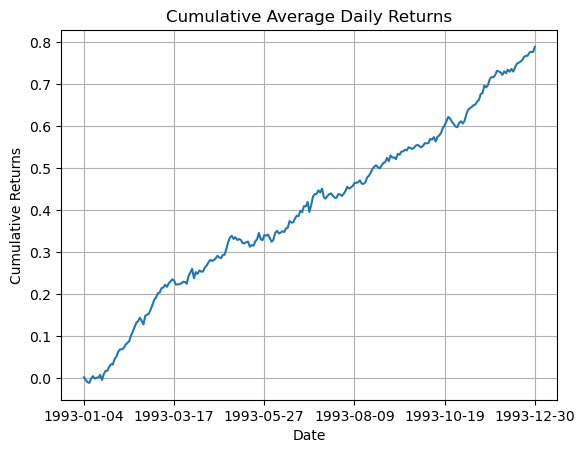

In [2]:
import matplotlib.pyplot as plt

returns.mean(axis=1).cumsum().plot(title='Cumulative Average Daily Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()


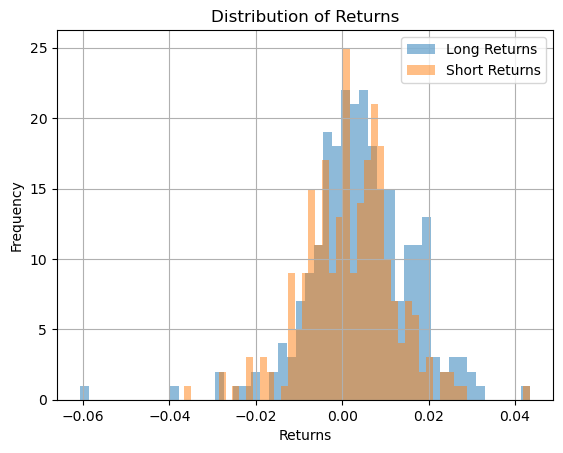

In [3]:
# Histogram of long returns
returns['Long'].hist(bins=50, alpha=0.5, label='Long Returns')
# Histogram of short returns
returns['Short'].hist(bins=50, alpha=0.5, label='Short Returns')
plt.title('Distribution of Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()

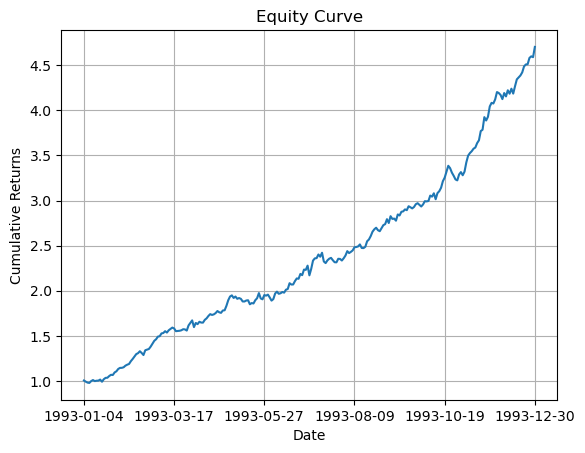

In [4]:
# Cumulative returns as an equity curve
(1 + returns.sum(axis=1)).cumprod().plot(title='Equity Curve')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()
